# Chapter 3: Pre-processing Time-Series

In [10]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest
from scipy.stats import boxcox

import numpy as np
from sklearn.impute import SimpleImputer

import pandas as pd

from typing import List
from dateutil.relativedelta import relativedelta, TH
import datetime
from workalendar.europe.united_kingdom import UnitedKingdom
from workalendar.usa import California
import calendar

from astral.sun import sun
from astral import LocationInfo

from datetime import date

import featuretools as ft
from featuretools.primitives import Minute, Hour, Day, Month, Year, Weekday

from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

np.random.seed(0)

%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [11]:
from sktime.datasets import load_arrow_head
from sktime.datatypes._panel._convert import from_nested_to_2d_array
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform

## Log and Power Transformations in Practice

In [13]:
pts = 10000
vals = np.random.lognormal(0, 1.0, pts)
vals[:5]

array([5.83603919, 1.49205924, 2.66109578, 9.40172515, 6.47247125])

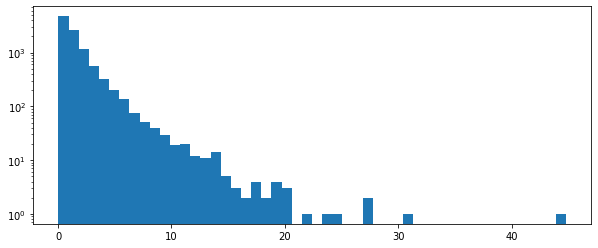

In [14]:
fig, ax = plt.subplots(figsize=[10, 4])
plt.hist(vals, bins=50)
plt.yscale("log", base=10)
plt.show()

In [15]:
scaler = StandardScaler()
vals_ss = scaler.fit_transform(vals.reshape(-1, 1))
_, p = normaltest(vals_ss)

In [16]:
print(f"Standard scaler values significance: {p[0]:.2f}")

Standard scaler values significance: 0.00


In [17]:
from sklearn.preprocessing import minmax_scale

vals_mm = minmax_scale(vals)
_, p = normaltest(vals_mm.squeeze())
print(f"Min-max scaler values significance: {p:.2f}")

Min-max scaler values significance: 0.00


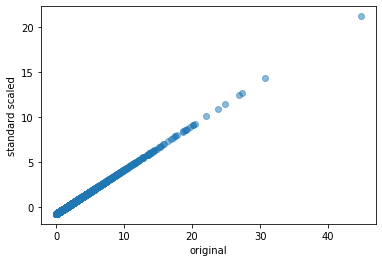

In [18]:
plt.scatter(x=vals, y=vals_ss, alpha=0.5)
plt.xlabel("original")
plt.ylabel("standard scaled")

plt.show()

Now apply a log transformation

In [19]:
log_transformed = np.log(vals)
_, p = normaltest(log_transformed)
print(f"significance: {p:.2f}")

significance: 0.46


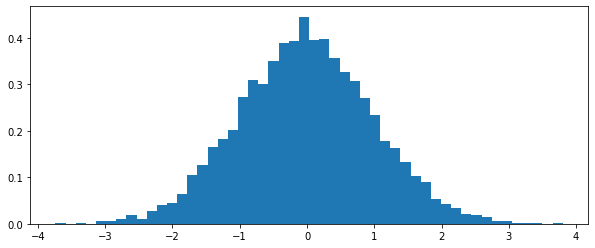

In [20]:
fig, ax = plt.subplots(figsize=[10, 4])
plt.hist(log_transformed, bins=50, density=True)
plt.yscale("linear")
plt.show()

In [21]:
vals_bc = boxcox(vals, 0.0)

In [22]:
_, p = normaltest(vals_bc)
print(f"significance: {p:.2f}")

significance: 0.46


# Imputation

In [23]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
SimpleImputer()
df = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(df)
print(imp_mean.transform(df))

[[nan, 2, 3], [4, nan, 6], [10, nan, 9]]
[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


In [24]:
UnitedKingdom().holidays()

[(datetime.date(2022, 1, 1), 'New year'),
 (datetime.date(2022, 1, 3), 'New Year shift'),
 (datetime.date(2022, 4, 15), 'Good Friday'),
 (datetime.date(2022, 4, 17), 'Easter Sunday'),
 (datetime.date(2022, 4, 18), 'Easter Monday'),
 (datetime.date(2022, 5, 2), 'Early May Bank Holiday'),
 (datetime.date(2022, 6, 2), 'Spring Bank Holiday'),
 (datetime.date(2022, 6, 3), 'Queen’s Platinum Jubilee bank holiday'),
 (datetime.date(2022, 8, 29), 'Late Summer Bank Holiday'),
 (datetime.date(2022, 12, 25), 'Christmas Day'),
 (datetime.date(2022, 12, 26), 'Boxing Day'),
 (datetime.date(2022, 12, 26), 'Christmas Shift'),
 (datetime.date(2022, 12, 27), 'Boxing Day Shift')]

In [25]:
def create_custom_holidays(year: int) -> List:
    custom_holidays = California().holidays()
    custom_holidays.append(
        (
            (
                datetime.datetime(year, 11, 1)
                + relativedelta(weekday=TH(+4))
                + datetime.timedelta(days=1)
            ).date(),
            "Black Friday",
        )
    )
    return {k: v for (k, v) in custom_holidays}


custom_holidays = create_custom_holidays(2021)

custom_holidays

{datetime.date(2021, 12, 31): 'New year (Observed)',
 datetime.date(2022, 1, 1): 'New year',
 datetime.date(2022, 1, 17): 'Birthday of Martin Luther King, Jr.',
 datetime.date(2022, 2, 21): "Washington's Birthday",
 datetime.date(2022, 3, 31): 'Cesar Chavez Day',
 datetime.date(2022, 5, 30): 'Memorial Day',
 datetime.date(2022, 7, 4): 'Independence Day',
 datetime.date(2022, 9, 5): 'Labor Day',
 datetime.date(2022, 11, 11): 'Veterans Day',
 datetime.date(2022, 11, 24): 'Thanksgiving Day',
 datetime.date(2022, 11, 25): 'Thanksgiving Friday',
 datetime.date(2022, 12, 25): 'Christmas Day',
 datetime.date(2022, 12, 26): 'Christmas Day (Observed)',
 datetime.date(2021, 11, 26): 'Black Friday'}

In [26]:
def is_holiday(current_date: datetime.date):
    """Determine if we have a holiday."""
    return custom_holidays.get(current_date, False)


today = datetime.date(2021, 4, 11)
is_holiday(today)

False

# Date Annotation

In [27]:
calendar.monthrange(2021, 1)

(4, 31)

In [28]:
def year_anchor(current_date: datetime.date):
    return (
        (current_date - date(current_date.year, 1, 1)).days,
        (date(current_date.year, 12, 31) - current_date).days,
    )


year_anchor(date.today())

(80, 284)

In [29]:
def month_anchor(current_date: datetime.date):
    last_day = calendar.monthrange(current_date.year, current_date.month)[1]
    return (
        (current_date - datetime.date(current_date.year, current_date.month, 1)).days,
        (
            current_date
            - datetime.date(current_date.year, current_date.month, last_day)
        ).days,
    )


month_anchor(date.today())

(21, -9)

# Paydays

In [30]:
def get_last_friday(current_date: datetime.date, weekday=calendar.FRIDAY):
    return max(
        week[weekday]
        for week in calendar.monthcalendar(current_date.year, current_date.month)
    )


get_last_friday(date.today())

25

# Seasons

In [31]:
YEAR = 2021
seasons = [
    ("winter", (date(YEAR, 1, 1), date(YEAR, 3, 20))),
    ("spring", (date(YEAR, 3, 21), date(YEAR, 6, 20))),
    ("summer", (date(YEAR, 6, 21), date(YEAR, 9, 22))),
    ("autumn", (date(YEAR, 9, 23), date(YEAR, 12, 20))),
    ("winter", (date(YEAR, 12, 21), date(YEAR, 12, 31))),
]


def is_in_interval(current_date: datetime.date, seasons):
    return next(
        season
        for season, (start, end) in seasons
        if start <= current_date.replace(year=YEAR) <= end
    )


is_in_interval(date.today(), seasons)

'spring'

## The Sun and Moon

In [32]:
CITY = LocationInfo("Bristol", "England", "Europe/London", 51.5, -0.116)


def get_sunrise_dusk(current_date: datetime.date, city_name="London"):
    s = sun(CITY.observer, date=current_date)
    sunrise = s["sunrise"]
    dusk = s["dusk"]
    return (sunrise - dusk).seconds / 3600


get_sunrise_dusk(date.today())

11.142222222222221

## Business Days

In [33]:
def get_business_days(current_date: datetime.date):
    last_day = calendar.monthrange(current_date.year, current_date.month)[1]
    rng = pd.date_range(current_date.replace(day=1), periods=last_day, freq="D")
    business_days = pd.bdate_range(rng[0], rng[-1])
    return len(business_days), last_day - len(business_days)


get_business_days(date.today())

(23, 8)

## Automated Feature Extraction

In [34]:
data = pd.DataFrame(
    {
        "Time": [
            "2014-01-01 01:41:50",
            "2014-01-01 02:06:50",
            "2014-01-01 02:31:50",
            "2014-01-01 02:56:50",
            "2014-01-01 03:21:50",
        ],
        "Target": [0, 0, 0, 0, 1],
    }
)
data["index"] = data.index
es = ft.EntitySet("My EntitySet")
es

Entityset: My EntitySet
  DataFrames:
  Relationships:
    No relationships

In [35]:
es.add_dataframe(
    dataframe_name="main_data_table", index="index", dataframe=data, time_index="Time"
)

Entityset: My EntitySet
  DataFrames:
    main_data_table [Rows: 5, Columns: 3]
  Relationships:
    No relationships

In [36]:
fm, features = ft.dfs(
    entityset=es,
    target_dataframe_name="main_data_table",
    trans_primitives=[Minute, Hour, Day, Month, Year, Weekday],
)

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/time-series-analysis-book-Kh4ECq7S-py3.9/lib/python3.9/site-packages/featuretools/synthesis/deep_feature_synthesis.py:156: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one dataframe in entityset, changing max_depth to "


In [37]:
fm

,Target,DAY(Time),HOUR(Time),MINUTE(Time),MONTH(Time),WEEKDAY(Time),YEAR(Time)
index,,,,,,,
0,0,1,1,41,1,2,2014
1,0,1,2,6,1,2,2014
2,0,1,2,31,1,2,2014
3,0,1,2,56,1,2,2014
4,1,1,3,21,1,2,2014


### TS Fresh

In [39]:
# settings = ComprehensiveFCParameters()
# extract_features(data, column_id='Time', default_fc_parameters=settings)

## ROCKET

In [40]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)
from_nested_to_2d_array(X_train).head()

,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__241,dim_0__242,dim_0__243,dim_0__244,dim_0__245,dim_0__246,dim_0__247,dim_0__248,dim_0__249,dim_0__250
0,-1.963009,-1.957825,-1.956145,-1.938289,-1.896657,-1.869857,-1.838705,-1.812289,-1.736433,-1.673329,...,-1.583857,-1.655329,-1.719153,-1.750881,-1.796273,-1.841345,-1.884289,-1.905393,-1.923905,-1.909153
1,-1.774571,-1.774036,-1.776586,-1.730749,-1.696268,-1.657377,-1.636227,-1.609807,-1.543439,-1.486174,...,-1.471688,-1.484666,-1.539972,-1.590150,-1.635663,-1.639989,-1.678683,-1.729227,-1.775670,-1.789324
2,-1.866021,-1.841991,-1.835025,-1.811902,-1.764390,-1.707687,-1.648280,-1.582643,-1.531502,-1.493609,...,-1.584132,-1.652337,-1.684565,-1.743972,-1.799117,-1.829069,-1.875828,-1.862512,-1.863368,-1.846493
3,-2.073758,-2.073301,-2.044607,-2.038346,-1.959043,-1.874494,-1.805619,-1.731043,-1.712653,-1.628022,...,-1.678942,-1.743732,-1.819801,-1.858136,-1.886146,-1.951247,-2.012927,-2.026963,-2.073405,-2.075292
4,-1.746255,-1.741263,-1.722741,-1.698640,-1.677223,-1.630356,-1.579440,-1.551225,-1.473980,-1.459377,...,-1.547111,-1.607101,-1.635137,-1.686346,-1.691274,-1.716886,-1.740726,-1.743442,-1.762729,-1.763428


In [42]:
rocket = Rocket(num_kernels=1000)
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

X_train_transform.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.951542,1.884432,0.533865,4.566438,0.565217,2.191599,0.761290,3.264788,0.792829,2.881423,...,0.415842,4.136299,0.367742,4.915391,0.597765,3.924132,0.615385,2.767788,0.358566,3.599695
1,0.991189,1.505634,0.593625,4.050572,0.608696,1.661951,0.722581,2.722317,0.776892,2.788133,...,0.415842,5.596117,0.425806,5.188452,0.486034,3.316855,0.642534,2.160664,0.418327,2.713454
2,0.977974,1.531245,0.565737,4.208391,0.608696,2.091934,0.722581,2.998482,0.804781,2.906463,...,0.405941,5.202308,0.419355,5.106456,0.564246,2.577097,0.651584,2.354139,0.410359,2.955911
3,0.885463,1.931911,0.541833,4.599593,0.552795,2.702683,0.748387,3.229963,0.752988,3.258503,...,0.544554,3.532910,0.316129,4.277352,0.502793,5.177021,0.624434,2.450406,0.378486,3.576932
4,1.000000,1.558333,0.541833,4.013694,0.677019,1.718398,0.819355,2.904498,0.776892,2.830923,...,0.425743,5.338102,0.419355,5.224523,0.536313,3.529494,0.592760,2.021520,0.422311,2.789996


## Shapelets in Practice

In [52]:
shapelets_transform = RandomShapeletTransform(
    time_limit_in_minutes=1,
    batch_size=10,
)
shapelets_transform.fit(X_train, y_train)

RandomShapeletTransform(batch_size=10, time_limit_in_minutes=1)

In [53]:
X_train_transform = shapelets_transform.transform(X_train)

In [54]:
X_train_transform[:10]

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.260902,0.257703,0.081247,0.022210,0.336080,0.167003,0.391696,0.429118,0.044582,0.248031,...,0.005473,0.011067,0.004026,0.002534,0.001244,0.003434,0.006039,0.004493,0.007653,0.020224
1,0.394673,0.425015,0.036169,0.009065,0.690744,0.581489,0.819891,1.136749,0.024820,0.373495,...,0.012374,0.005938,0.002253,0.002672,0.002194,0.000495,0.001671,0.002929,0.007671,0.055588
2,0.462531,0.416018,0.100926,0.032307,0.545491,0.414003,0.608869,0.976972,0.063462,0.398140,...,0.007373,0.003420,0.001469,0.003709,0.006028,0.002976,0.002818,0.003949,0.004218,0.058359
3,0.043508,0.084577,0.114733,0.020941,0.140437,0.016110,0.265013,0.076737,0.035178,0.177112,...,0.007796,0.015195,0.003599,0.002283,0.017440,0.001886,0.004869,0.004865,0.005104,0.033969
4,0.345057,0.353023,0.024416,0.011235,0.589995,0.462352,0.699847,1.000639,0.008173,0.387973,...,0.006787,0.009127,0.001860,0.005313,0.005395,0.009863,0.003148,0.002773,0.003170,0.005380
5,0.376585,0.372429,0.028642,0.032143,0.692543,0.609660,0.714855,1.166330,0.041951,0.286823,...,0.002918,0.000181,0.001748,0.004396,0.008658,0.000418,0.003008,0.002124,0.005835,0.053758
6,0.150452,0.177043,0.239908,0.059898,0.193264,0.156559,0.011622,0.292556,0.075065,0.071887,...,0.005657,0.014786,0.002280,0.005050,0.027949,0.002977,0.004719,0.001489,0.003109,0.024004
7,0.360702,0.400332,0.031936,0.016527,0.676273,0.522990,0.823805,1.032269,0.023934,0.317478,...,0.013254,0.006609,0.002392,0.006428,0.007909,0.003500,0.005309,0.005487,0.009986,0.001136
8,0.433855,0.445930,0.099314,0.029649,0.656403,0.535263,0.724042,1.133917,0.060020,0.399256,...,0.008650,0.003442,0.003517,0.001827,0.002367,0.003560,0.001597,0.002029,0.002995,0.018931
9,0.045621,0.197948,0.292132,0.045948,0.122133,0.047329,0.314093,0.010424,0.062612,0.191456,...,0.003670,0.016054,0.005813,0.001994,0.037416,0.000970,0.010009,0.004316,0.002844,0.002380
